# Correlation Power Analysis Example

- Setup for example AES
- Uses NewAE CW305 board

## Data Acquisition

In [1]:
# capture_pynq
# requires pynqserver to run on Pynq
# requires FOBOS Shield
# uses NewAE CW305 as DUT
import os
import sys
import shutil
import json
import numpy as np
from foboslib import projmgr
from foboslib.ctrl import pynqctrl
from foboslib.ctrl.fobosctrl import FOBOSCtrl
from foboslib.fobosTVGen import FobosTVGen
from foboslib.dut import cw305dut

#######################################################
# Acquisition Configuration
acqConf = {}
# Connection to Control Board
acqConf['ip'] = '192.168.10.98'
acqConf['port'] = 9995
# File Names and Locations
acqConf['workspace']       = "fobosworkspace"   # Folder to store projects
acqConf['projectName']     = "aes"              # Name of this project. Files will be in workspace/projectName/
acqConf['keyFile']         = "key.txt"          # key, must be provided in workspace/projectName/ directory
acqConf['plainFile']       = "plaintext.txt"    # plaintext in hex, auto-generated
acqConf['dinFile']         = "dinFile.txt"      # test vectors in FOBOS format incl. plaintext and key, auto-generated
acqConf['cipherFile']      = "ciphertext.txt"   # observed ciphertext, result from applying test vectors
acqConf['traceFile']       = "powerTraces.npy"  # Name of file for recording power traces
# Cipher Specific Information
acqConf['bitFile']         = "aes_cw305.bit"    # Bitstream for programming the DUT, same directory as this notebook
acqConf['blockSize']       = 16                 # size of a block of plaintext in bytes
acqConf['cipherSize']      = 16                 # size of a block of cyphertext in bytes
acqConf['keySize']         = 16                 # size of the key in bytes
# Acquistion configuration
acqConf['traceNum']        = 100                # number of traces to run
acqConf['samplingFreq']    = 100                # sampling frequency of the Oscilloscope in Msps [range: 1 - 100]
acqConf['DUTClk']          = 1                  # clock frequency of the DUT in MHz [range: 1 - 100]
acqConf['samplesPerTrace'] = 2000               # number of ADC samples in one trace
acqConf['ADCGain']         = 50                 # amplification of ADC input signal [range: 0 - 60]
acqConf['ADCHiLo']         = 1                  # 0 - low amplification, 1 - high amplification

In [2]:
# Configure project directories
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(acqConf['workspace'])
pm.setProjName(acqConf['projectName'])
projDir = pm.getProjDir()

Successfully created workspace directory at fobosworkspace
Successfully created workspace directory at fobosworkspace/aes


In [3]:
# create key file in tje workspace directory
KEY = "01 23 45 67 89 ab cd ef 00 11 22 33 44 55 66 77"
keyFileName = os.path.join(projDir, acqConf['keyFile'])
keyFile = open(keyFileName, "w")
keyFile.write(KEY )
keyFile.close()

In [4]:
# Generate test vectors
tvGen = FobosTVGen(traceNum=acqConf['traceNum'],
                   blockSize=acqConf['blockSize'],
                   keySize=acqConf['keySize'],
                   cipherSize=acqConf['cipherSize'],
                   dinFile= os.path.join(projDir, acqConf['dinFile']),
                   plaintextFile=os.path.join(projDir, acqConf['plainFile']),
                   keyFile=os.path.join(projDir, acqConf['keyFile'])
                   )
tvGen.generateTVs()

Generating 100 test vectors...
    KeyFile = fobosworkspace/aes/key.txt
    PlaintextFile = fobosworkspace/aes/plaintext.txt
    Block Size (bytes) = 16
    Ciphertext Size (bytes) = 16
    Key Size (bytes)= 16
Done.


In [5]:
# Create capture directory
captureDir = pm.getCaptureDir()
# Open input files
plainFileName = os.path.join(projDir, acqConf['plainFile'])
tvFileName = os.path.join(projDir, acqConf['dinFile'])
tvFile = open(tvFileName, "r")
# Open output files
cipherFileName = os.path.join(captureDir, acqConf['cipherFile'])
traceFileName = os.path.join(captureDir, acqConf['traceFile'])
cipherFile = open(cipherFileName, "w")
traceFile = open(traceFileName, "a+b")
# save input files
shutil.copy(tvFileName, captureDir)
shutil.copy(plainFileName, captureDir)
# save config to a file
configFile = open(os.path.join(captureDir, 'acquisitionConfig.json'), "w")
configFile.write(json.dumps(acqConf, indent=4))
configFile.close()

Successfully created new capture directory at fobosworkspace/aes/capture/attempt-01


In [6]:
### Connecting to the Pynq Board
# lock file is: /tmp/fobos.lock
# delete the lock file manually if its stale
ctrl = pynqctrl.PYNQCtrl(acqConf['ip'], acqConf['port'])

Acquired hardware lock


In [7]:
# Apply settings to the Pynq Board
ctrl.setDUTClk(acqConf['DUTClk'])                 # setting DUT clock resets all modules using this clock
ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)    # Using Target connector -> INTERFACE_4BIT
ctrl.setDUT(FOBOSCtrl.CW305)                      # Adjust Target connector pinout for DUT
ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)           # Trigger is active during DUT operation
ctrl.setOutLen(acqConf['cipherSize'])
ctrl.setSamplingFrequency(acqConf['samplingFreq'])
ctrl.setSamplesPerTrace(acqConf['samplesPerTrace'])
ctrl.setADCGain(acqConf['ADCGain'])
ctrl.setADCHiLo(acqConf['ADCHiLo'])

0

In [8]:
# Program the DUT
dut = cw305dut.CW305DUT()
dut.setBitFile(acqConf['bitFile'])
dut.program()

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


programming DUT. Please wait ...
CW305 DUT programming done!


In [9]:
# Run the data acquisition
print('Processing test vectors ...')
traceNum = 0
while traceNum < acqConf['traceNum']:
    data = tvFile.readline()
    status, result, trace = ctrl.processData2(data, acqConf['cipherSize'])
    cipherFile.write(result + "\n")
    np.save(traceFile, trace)
    if traceNum % 100 == 0:
        sys.stdout.write('Progress:' + "{:.2f}".format(traceNum/acqConf['traceNum']*100) + '%\r')
        sys.stdout.flush()
    traceNum += 1
print('Data acquisition complete.')
# release and reset control board.
ctrl.disconnect() 
# close all files
traceFile.close()
cipherFile.close()
tvFile.close()

Processing test vectors ...
Data acquisition complete.
Released hardware lock.


<Figure size 432x288 with 0 Axes>

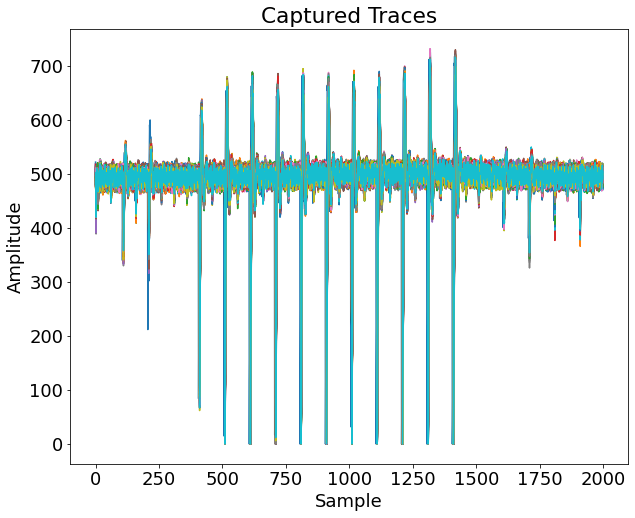

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 18})
traceFile = open(traceFileName, "r+b")
maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Captured Traces')
for i in range(min(maxtrace, acqConf['traceNum'])):
    trace = np.load(traceFile)
    plt.plot(trace)

plt.savefig(os.path.join(captureDir, 'traces.png'),facecolor=fig.get_facecolor())
# plt.close()
traceFile.close()

In [11]:
print(result)

bf 0a bb 14 26 dc 88 2c 88 b2 28 5d 1e 15 4e 39


## Correlation Power Analysis

In [12]:
import foboslib.cpa as cpa
import foboslib.traceset as traceset
import foboslib.powermodels.AESFirstLast as powermodel #code to calculate hypothetical power
import foboslib.powermodels.utils as powermodelUtils

In [13]:
# Configure project directories
WORKSPACE = os.path.dirname(captureDir)           # or specify other directory if needed
ATTEMPT_DIR = os.path.basename(captureDir)        # or specify other directory if needed, e.g., "attempt-24"

In [14]:
# Create analysis project directory
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(ATTEMPT_DIR)
projDir = pm.getProjDir()
analysisDir = pm.getAnalysisDir()

Successfully created new analysis directory at fobosworkspace/aes/capture/attempt-01/analysis/attempt-01


In [15]:
# read acquisition settings
cpaConf = {}
configFile = open(os.path.join(projDir, 'acquisitionConfig.json'))
acqConf = json.load(configFile)
configFile.close()
print(f'Acquisition config = {acqConf}')
cpaConf['traceNum'] = acqConf['traceNum']

# Configure file names
HYPO_FILE = os.path.join(projDir, "hypotheticalPower.npy")
TRACES_FILE = os.path.join(projDir, acqConf['traceFile'])
PLAIN_TEXT = os.path.join(projDir, acqConf['plainFile'])
CIPHER_TEXT = os.path.join(projDir, acqConf['cipherFile'])

Acquisition config = {'ip': '192.168.10.98', 'port': 9995, 'workspace': 'fobosworkspace', 'projectName': 'aes', 'keyFile': 'key.txt', 'plainFile': 'plaintext.txt', 'dinFile': 'dinFile.txt', 'cipherFile': 'ciphertext.txt', 'traceFile': 'powerTraces.npy', 'bitFile': 'aes_cw305.bit', 'blockSize': 16, 'cipherSize': 16, 'keySize': 16, 'traceNum': 100, 'samplingFreq': 100, 'DUTClk': 1, 'samplesPerTrace': 2000, 'ADCGain': 50, 'ADCHiLo': 1}


In [16]:
# Create hypothetical power model

#if os.path.isfile(HYPO_FILE):
    # already exists. load it
#    hypotheticalPower = powermodelUtils.loadHypoPower(HYPO_FILE)
#else:
    # not there. generate it
hypotheticalPower = powermodel.getHypotheticalPower(PLAIN_TEXT, CIPHER_TEXT, cpaConf['traceNum'])
powermodelUtils.saveHypoPower(hypotheticalPower, HYPO_FILE)
## end if
powermodelUtils.showHypoPower(hypotheticalPower, plainFile=PLAIN_TEXT, cipherFile=CIPHER_TEXT)

---- Loading powermodel input data:
Plaintext :
Matrix shape is (100, 16)
[[ac a 7f ... cc 21 d8]
 [43 b3 4e ... 7d e5 d8]
 [9 a4 74 ... d6 66 62]
 ...
 [75 33 53 ... 6e 61 f8]
 [5b d8 37 ... ee d5 15]
 [cb ff da ... ee e2 7c]]

Ciphertext :
Matrix shape is (100, 16)
[[6b 65 3 ... 90 6b 27]
 [83 9c b9 ... 78 b4 61]
 [92 24 64 ... d6 4c d8]
 ...
 [e7 89 ad ... 4d c0 32]
 [22 b6 96 ... 59 2b ce]
 [bf a bb ... 15 4e 39]]

---- Loading powermodel input data complete.
---- Calculating hypothetical power for all subkeys:
---- Hypothetical power calculation done.
Saving hypthetical power to fobosworkspace/aes/capture/attempt-01/hypotheticalPower.npy.
saving done.
Power model :
Hypothetical power matrix for subkey 0:
Matrix shape is (100, 256)
[[3 4 4 ... 4 0 6]
 [4 4 6 ... 4 2 3]
 [6 5 5 ... 4 2 5]
 ...
 [4 6 5 ... 2 4 3]
 [5 3 6 ... 3 3 6]
 [3 6 4 ... 4 2 4]]

Hypothetical power matrix for subkey 1:
Matrix shape is (100, 256)
[[5 4 2 ... 3 7 5]
 [1 5 3 ... 3 5 3]
 [5 4 6 ... 3 2 6]
 ...
 [3 

Loading raw traces from file: fobosworkspace/aes/capture/attempt-01/powerTraces.npy
Please wait ...
Loading done.
The shape of the traces matrix is (100, 4)


<Figure size 432x288 with 0 Axes>

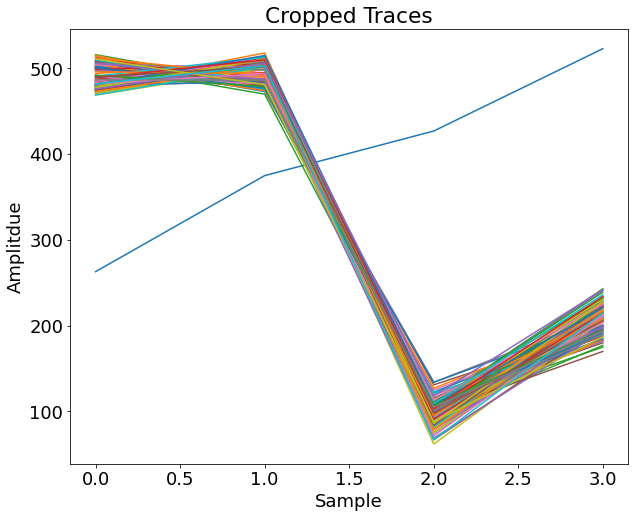

In [17]:
# load traces from file and crop them.
cpaConf['cropStart'] = 408
cpaConf['cropEnd'] = 412
traceSet = traceset.TraceSet(traceNum=cpaConf['traceNum'],
                            fileName=TRACES_FILE,
                            cropStart=cpaConf['cropStart'],
                            cropEnd=cpaConf['cropEnd'])

measuredPower = traceSet.traces
print(f'The shape of the traces matrix is {measuredPower.shape}')


maxtrace = 100
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.rcParams.update({'font.size': 18})
traceFile = open(traceFileName, "r+b")
maxtrace = 100
plt.figure(figsize=(10,8))
plt.xlabel('Sample')
plt.ylabel('Amplitdue')
plt.title('Cropped Traces')
for i in range(min(maxtrace, cpaConf['traceNum'])):
    plt.plot(measuredPower[i])
plt.savefig(os.path.join(analysisDir, 'cropped_traces.png'),facecolor=fig.get_facecolor())

In [20]:
# Configure the attack
numKeys = 16              # number of subkey bytes to attack
cpaConf['plot'] = True    # generate plots, [True|False]
#####################
# Run the attack
cpaAttacker = cpa.CPA()
C = cpaAttacker.doCPA(measuredPower=measuredPower,
                      hypotheticalPower=hypotheticalPower,
                      numTraces= cpaConf['traceNum'],
                      analysisDir=analysisDir,
                      MTDStride= 100,
                      numKeys = numKeys,
                      plot= cpaConf['plot'], # enable/disable plots
                      plotSize=(10,8),
                      plotFontSize=18
                      )

Running CPA attack. Please wait ...
subkey number = 0, subkey value = 0xa5, correlation = 0.31444874205121, at sample = 3
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 1, subkey value = 0x77, correlation = 0.31053536710884366, at sample = 2
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 2, subkey value = 0x1e, correlation = 0.3107822549252044, at sample = 0
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 3, subkey value = 0xf1, correlation = 0.32092604489533255, at sample = 1
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 4, subkey value = 0x53, correlation = 0.33239346358043786, at sample = 1
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 5, subkey value = 0x36, correlation = 0.3240438651285444, at sample = 0
    plotting correlation graph.
    Plotting MTD graph.
subkey number = 6, subkey value = 0x96, correlation = 0.4117667776743441, at sample = 3
    plottin

In [21]:
# Writing analysis configuration to file.
configFile = open(os.path.join(analysisDir, 'analysisConfig.json'), "w")
configFile.write(json.dumps(cpaConf, indent=4))
configFile.close()